# Binary Classification Pipeline Hands-on

---
##  _Zichen Wang_
## Ma'ayan Lab
## Data Mining and Network Analysis (Fall 2016)
## _Nov. 15, 2016_
---


# Pipeline for typical single label classification analysis

1. Data cleaning: obtain the data and clean it (X, y)
1. Transformations: normalization, scaling
1. Feature extraction
1. Partition data to training and test sets
    + Feature selection
    + Train classifier 
    + Evaluate classifier 
1. Apply classifier to new data

---

## 1. Data cleaning: obtain the data and clean it (X, y)

In [1]:
from __future__ import division
import numpy as np
RNG = 10
np.random.seed(RNG)

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Create synthetic data
X, y = make_classification(n_classes=2, class_sep=2, 
                           weights=[0.1, 0.9], # the ratios of the two classes
                           n_informative=3, n_redundant=4, flip_y=0.02,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=RNG)

# Force them to be on different scales
X = np.multiply(X, np.arange(20)) + np.arange(20)

print 'Shape of X: ', X.shape, 'shape of y:', y.shape

Shape of X:  (1000, 20) shape of y: (1000,)


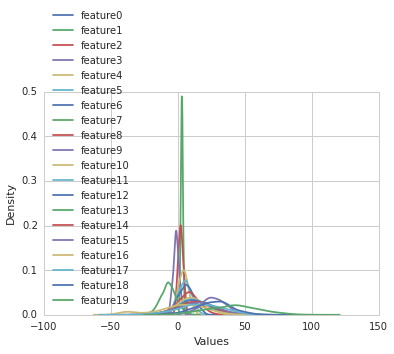

In [3]:
# Examine the distribution of the 10 features over all the samples
fig, ax = plt.subplots()
for j in range(20):
    ax = sns.kdeplot(X[:,j], ax=ax, label='feature%d' % j)

ax.set_ylabel('Density')
ax.set_xlabel('Values')
plt.show()

## 2. Transformations (normalization, scaling)

- Standard scaling (Z-score)
- Min-Max scaling
- Robust scaling

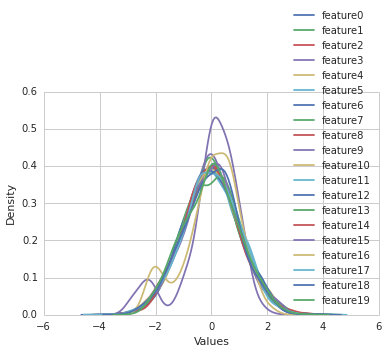

In [4]:
from sklearn.preprocessing import StandardScaler
# Scale the features using z-score
scl = StandardScaler()
X = scl.fit_transform(X)
# Examine the distribution of the 10 features over all the samples again
fig, ax = plt.subplots()
for j in range(20):
    ax = sns.kdeplot(X[:,j], ax=ax, label='feature%d' % j)

ax.set_ylabel('Density')
ax.set_xlabel('Values')
plt.show()

## 3. Feature extraction (dimensionality reduction)

Reduce the number of features required to describe the structure of the data

In [5]:
from sklearn.decomposition import PCA

## Use PCA to reduce the dimensionality 
pca = PCA(n_components=10)
X = pca.fit_transform(X)
print 'Shape of X after PCA to the first 10 dimensions: ', X.shape

Shape of X after PCA to the first 10 dimensions:  (1000, 10)


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


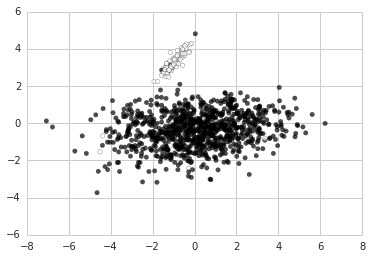

In [6]:
## PCA can also be used to visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
plt.show()

## 4. Partition the data (Straitification matters!)

- Train-test split
- Train-valid-test split
- Cross-validation (CV)

In [7]:
from sklearn.cross_validation import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                 test_size=0.3, 
                 stratify=None, ## Change this
                 random_state=RNG)

print 'Before spliting:'
print X.shape, y.shape, y.sum()/y.shape[0]

print 'After spliting:'
print X_train.shape, y_train.shape, y_train.sum()/y_train.shape[0]
print X_test.shape, y_test.shape, y_test.sum()/y_test.shape[0]

Before spliting:
(1000, 10) (1000,) 0.894
After spliting:
(700, 10) (700,) 0.882857142857
(300, 10) (300,) 0.92


### 4.a. Feature selection
### 4.b. Train classifier

In [8]:
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

## Initiate a FS-Logit pipeline
fs = SelectKBest(f_classif, k=2)
logit = LogisticRegression()

pipeline = Pipeline([
        ('fs', fs),
        ('logit', logit)
    ])


In [9]:
# Train classifier
pipeline.fit(X_train, y_train)
# Get prediction on test set
y_test_preds = pipeline.predict(X_test)
y_test_probas = pipeline.predict_proba(X_test)
print y_test_preds.shape, y_test_probas.shape

(300,) (300, 2)


In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score

# Evaluate predictions
print 'Accuracy: %.5f' % accuracy_score(y_test, y_test_preds)
print 'F1 score: %.5f' % f1_score(y_test, y_test_preds)
print 'AUROC: %.5f' % roc_auc_score(y_test, y_test_probas[:, 1])
print 'AUPRC: %.5f' % average_precision_score(y_test, y_test_probas[:, 1])

## Results from not straitified split
# Accuracy: 0.98000
# F1 score: 0.98909
# AUROC: 0.93825
# AUPRC: 0.98502

## Results from straitified split
# Accuracy: 0.99000
# F1 score: 0.99443
# AUROC: 0.94018
# AUPRC: 0.98791

Accuracy: 0.98000
F1 score: 0.98909
AUROC: 0.93825
AUPRC: 0.98502


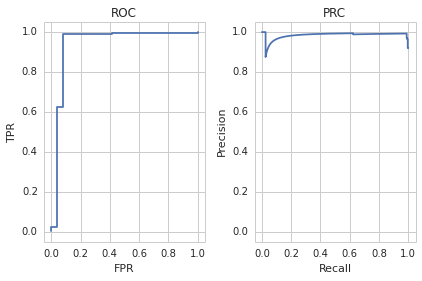

In [11]:
# To plot ROC and PRC
from sklearn.metrics import roc_curve, precision_recall_curve

# Compute FPR, TPR, Precision by iterating classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_probas[:, 1])
precision, recall, thresholds = precision_recall_curve(y_test, y_test_probas[:, 1])

# Plot
fig, axes = plt.subplots(1, 2)
axes[0].plot(fpr, tpr)
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC')

axes[1].plot(recall, precision)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PRC')

axes[0].set_xlim([-.05, 1.05])
axes[0].set_ylim([-.05, 1.05])
axes[1].set_xlim([-.05, 1.05])
axes[1].set_ylim([-.05, 1.05])

fig.tight_layout()
plt.show()

## Recommended reading materials

0. "Points of Significance" series in _Nature Methods_
    + [Logistic regression](http://www.nature.com/nmeth/journal/v13/n7/full/nmeth.3904.html)
    + [Classification evaluation](http://www.nature.com/nmeth/journal/v13/n8/full/nmeth.3945.html)
    + [Model selection and overfitting](http://www.nature.com/nmeth/journal/v13/n9/full/nmeth.3968.html)

0. [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) by Hastie T, Tibshirani R, and Friedman J.